In [2]:
!curl --header "Host: storage.googleapis.com" --header "User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.85 Safari/537.36 Edg/90.0.818.46" --header "Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header "Accept-Language: en-US,en;q=0.9" --header "Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/11835/224935/compressed/train.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1619508585&Signature=amzijC5XFZtdstk4fvw2L%2FoGQniPopEsN4E1clcp4FNiHvbbRi4LS5VXz%2FC8kpPcK0AVm8wW6prvtVEFfnzb9%2FtflukQU77uUdBXf8qWM82%2BBSF8fJyD0Yl6vL42IVKFIUa0i9wDzHnrnFDXerDJYy452%2BK3cnO5xW4SZRHBFhJzMEzED1cTnK%2BX2gdZCDEG3z%2Baos0K7Sw8gj%2FY7jYj5vjYki7hT5BenuKyuu3cXPfNINmhsGYFHY6bwsP1craa0AojXvUzwwHB6NEdV%2B4EexfjM3Ut7t0IQ6ktq7WJYm6SrzdsdNqCbzp5sECx2ngNKhPFezSl1G%2FzSHQn7dtkSw%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.csv.zip" -L -o "train.csv.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  435M  100  435M    0     0  24.2M      0  0:00:17  0:00:17 --:--:-- 28.2M


In [3]:
!unzip '/content/train.csv.zip'

Archive:  /content/train.csv.zip
  inflating: train.csv               


In [4]:
import pandas as pd
from flask import Flask, render_template,request
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

from tensorflow.keras.utils import plot_model
import timeit
import joblib


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from sklearn.metrics import log_loss
import scipy.signal as signal

import pickle
import lightgbm
from lightgbm import LGBMClassifier

In [ ]:
print(tf.__version__)

2.4.1


In [5]:
df= pd.read_csv('train.csv')

In [ ]:
df

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event
0,1,CA,0.011719,1,0.387046,0.428686,0.424623,0.459177,0.593822,0.496168,0.399734,0.356938,0.590240,0.591297,0.521062,0.540994,0.509697,0.535817,0.612048,0.593882,0.396459,0.593875,0.472502,0.326867,0.274755,0.931052,0.223995,A
1,1,CA,0.015625,1,0.387816,0.428217,0.425544,0.461508,0.594570,0.495628,0.399418,0.357056,0.590406,0.591238,0.521884,0.540561,0.509989,0.536029,0.605679,0.594738,0.396818,0.593614,0.473759,0.327722,0.274762,0.931066,0.223989,A
2,1,CA,0.019531,1,0.388530,0.427731,0.426408,0.463713,0.595288,0.495078,0.399095,0.357173,0.590547,0.591158,0.522664,0.540101,0.510273,0.536215,0.599616,0.595534,0.397132,0.593335,0.474812,0.328513,0.274775,0.931093,0.223977,A
3,1,CA,0.023438,1,0.389144,0.427218,0.427171,0.465683,0.595944,0.494518,0.398760,0.357291,0.590642,0.591036,0.523356,0.539596,0.510544,0.536355,0.594118,0.596210,0.397364,0.593024,0.475491,0.329185,0.274795,0.931133,0.223959,A
4,1,CA,0.027344,1,0.389635,0.426676,0.427806,0.467343,0.596511,0.493945,0.398411,0.357422,0.590675,0.590860,0.523915,0.539038,0.510799,0.536445,0.589394,0.596721,0.397488,0.592672,0.475655,0.329700,0.274822,0.931187,0.223935,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4867416,13,SS,99.991005,1,0.368885,0.393428,0.430548,0.459547,0.559941,0.462079,0.380862,0.349070,0.577352,0.565839,0.516981,0.492618,0.505243,0.532493,0.597277,0.588011,0.383877,0.576525,0.460367,0.318230,0.165976,0.616414,0.345512,A
4867417,13,SS,99.993004,0,0.371975,0.394283,0.429593,0.461101,0.558719,0.462978,0.382964,0.350945,0.578645,0.568777,0.517968,0.500426,0.505792,0.532578,0.591541,0.587921,0.385991,0.577562,0.465460,0.319325,0.173328,0.639896,0.349876,A
4867418,13,SS,99.994003,1,0.375441,0.395206,0.428769,0.463158,0.557608,0.463815,0.385225,0.353016,0.580018,0.571946,0.519002,0.509456,0.506365,0.532612,0.584452,0.587765,0.388243,0.578592,0.470965,0.320423,0.181932,0.667354,0.354979,A
4867419,13,SS,99.997002,0,0.379141,0.396137,0.428079,0.465587,0.556564,0.464557,0.387590,0.355199,0.581422,0.575204,0.520044,0.519339,0.506937,0.532585,0.576303,0.587529,0.390550,0.579513,0.476647,0.321491,0.191441,0.697692,0.360618,A


In [ ]:
def noise_plus_transform(features,df):
    for i in features:
        df[i]=noise_removal(df[i],0.1)
        df[i]=scaler.fit_transform(df[[i]])
    return df

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
def noise_removal(noisy_data,Wn):
    N = 3
    B, A = signal.butter(N, Wn)
    return signal.lfilter(B,A, noisy_data)


In [ ]:

def noise_plus_transform(features,df):
    
    for i in features:
        df[i]=noise_removal(df[i],0.1)
        df[i]=scaler.fit_transform(df[[i]])
    return df
# noise_plus_transform(df.columns[5:27],df)

In [ ]:
def x_rem_fe(df):

  df=df.drop(['experiment','event'],axis=1)
#   encoderpl= {'A':0,'B':1,'C':2,'D':3}
#   y=df['event'].apply(lambda x: encoderpl[x])

  return df


In [ ]:
def auto_encoder(model,df):
#     features = ["eeg_fp1","eeg_f7","eeg_f8","eeg_t4","eeg_t6","eeg_t5","eeg_t3","eeg_fp2","eeg_o1","eeg_p3","eeg_pz","eeg_f3","eeg_fz","eeg_f4","eeg_c4","eeg_p4","eeg_poz","eeg_c3","eeg_cz","eeg_o2"]

    encoder = load_model(model)
    X=df[df.columns[4:24]]

#     X_train, X_test = train_test_split(X, test_size=0.33, random_state=1)
    X_train_encode = encoder.predict(X)
  # encode the test data
#     X_test_encode = encoder.predict(X_test)
#     x_final = np.vstack((X_train_encode ,X_test_encode))
    df['eeg_fe_1'] = X_train_encode[:,0]
    df['eeg_fe_2'] = X_train_encode[:,1]
    df['eeg_fe_3'] = X_train_encode[:,2]
    df['eeg_fe_4'] = X_train_encode[:,3]
    feats= ['eeg_fe_1','eeg_fe_2','eeg_fe_3','eeg_fe_4']
    
    noise_plus_transform(feats,df)
    
    return df



In [ ]:
def pipeline(df,autoencoder):
    df=noise_plus_transform(df.columns[5:27],df)
    df=auto_encoder(autoencoder,df)
    df=x_rem_fe(df)
    return df

In [ ]:
def final_1(df):

  pipeline(df,'encoder.h5')
  df=df.drop(['experiment','event'],axis=1)
  
  model = joblib.load('lgbm_model.pkl')
  y_test_predictions= model.predict_proba(df)
  # y_test_loss =log_loss(y_tests, y_test_predictions)
  return y_test_predictions

  
    


In [ ]:
predictions=final_1(df)
print('The predictions for the data is  ',predictions)

The predictions for the data is   [[0.60555458 0.02161086 0.31501773 0.05781683]
 [0.60556859 0.02161132 0.31500504 0.05781506]
 [0.60560536 0.02161252 0.31497161 0.05781051]
 ...
 [0.60138334 0.02490696 0.3265481  0.04716159]
 [0.60130447 0.02490778 0.32662999 0.04715776]
 [0.60123095 0.02490841 0.326706   0.04715464]]


In [ ]:
def final_2(df):
  start = timeit.timeit()
  # df=reduce_mem_usage(df)

  features=['r','gsr','ecg','eeg_fp1',"eeg_f7","eeg_f8","eeg_t4","eeg_t6","eeg_t5","eeg_t3","eeg_fp2","eeg_o1","eeg_p3","eeg_pz","eeg_f3","eeg_fz","eeg_f4","eeg_c4","eeg_p4","eeg_poz","eeg_c3","eeg_cz","eeg_o2"]
  for i in features:
    df[i]=noise_removal(df[i],0.1)
    df[i]=scaler.fit_transform(df[[i]])
  
  features = ["eeg_fp1","eeg_f7","eeg_f8","eeg_t4","eeg_t6","eeg_t5","eeg_t3","eeg_fp2","eeg_o1","eeg_p3","eeg_pz","eeg_f3","eeg_fz","eeg_f4","eeg_c4","eeg_p4","eeg_poz","eeg_c3","eeg_cz","eeg_o2"]
  X=df[features]
  encoder= {'A':0,'B':1,'C':2,'D':3}
  y=df['event'].apply(lambda x: encoder[x])
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
  encoder = load_model('/content/encoder.h5')
  # encode the train data
  X_train_encode = encoder.predict(X_train)
  # encode the test data
  X_test_encode = encoder.predict(X_test)
  x_final = np.vstack((X_train_encode ,X_test_encode))
  df['eeg_fe_1'] = x_final[:,0]
  df['eeg_fe_2'] = x_final[:,1]
  df['eeg_fe_3'] = x_final[:,2]
  df['eeg_fe_4'] = x_final[:,3]
  feats= ['eeg_fe_1','eeg_fe_2','eeg_fe_3','eeg_fe_4']
  for i in feats:
    df[i]=scaler.fit_transform(df[[i]])
  x=df.drop(['experiment','event'],axis=1)
  X_trains, X_tests, y_trains, y_tests = train_test_split(x, y, test_size=0.33, random_state=1)
  Log_reg=pickle.load(open('lgbm_load','rb'))
  y_test_predictions= Log_reg.predict_proba(X_tests)
  y_test_loss =log_loss(y_tests, y_test_predictions) 
  end = timeit.timeit()
  time=end-start
  
  return y_test_predictions,y_test_loss,time




  

In [ ]:
y_test_predictions,y_test_loss,time=final_2(df)
print("Time Taken",time)
print('Predicted state :',y_test_predictions[0])
print('Evaluation Metric log loss :',y_test_loss)


Time Taken -0.0010004370005844976
Predicted state : [0.60451471 0.02434449 0.3207837  0.05035709]
Evaluation Metric log loss : 0.9082386224277207


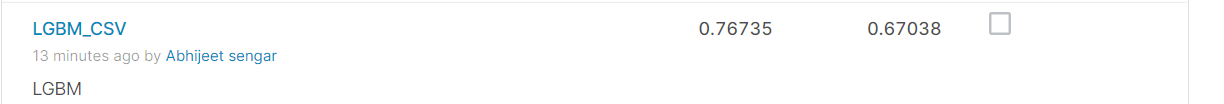